In [2]:
import os
from datetime import datetime

import pandas as pd
import numpy as np
from sklearn.metrics import balanced_accuracy_score

from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D



sns.set()

In [16]:
folder = "ae_clusters"

In [52]:
datafile="data/{}/fold_-1_hidden_states.csv".format(folder)
data = pd.read_csv(datafile)
data = data.drop(data[data.DX_mask == 0].index)
data = data.dropna(subset=["DXCHANGE"])
data.DXCHANGE = data.DXCHANGE.astype(int)

#data.DXCHANGE = data.DXCHANGE.where(data.DXCHANGE > 3, 0)
#data = data.drop(data[data.DXCHANGE == 0].index)
#data.DXCHANGE = data.DXCHANGE.where(data.DXCHANGE < 4, 1)
x = data.iloc[:,4:132]
x

,hidden_0,hidden_1,hidden_2,hidden_3,hidden_4,hidden_5,hidden_6,hidden_7,hidden_8,hidden_9,...,hidden_118,hidden_119,hidden_120,hidden_121,hidden_122,hidden_123,hidden_124,hidden_125,hidden_126,hidden_127
0,-0.116346,-0.000285,0.182610,-0.000042,-0.417371,0.624433,-0.226461,0.006645,0.737447,-0.001923,...,-0.011210,-0.126778,-0.050115,0.860026,-0.830088,0.060417,-0.509639,0.459874,0.419408,-0.011354
1,-0.211547,-0.000236,0.240845,-0.000038,-0.407337,0.901533,-0.333458,0.011926,0.767514,-0.013362,...,-0.014926,-0.078853,-0.186925,0.978818,-0.884275,0.758333,-0.799156,0.875827,0.378984,-0.033929
3,-0.272258,0.000120,0.332351,-0.000035,-0.423084,0.944609,-0.473477,0.017333,0.813940,-0.148387,...,-0.027888,0.314195,-0.447716,0.989262,-0.824456,0.948237,-0.905568,0.940852,0.328312,-0.047147
7,-0.303190,0.001740,0.460817,-0.000031,-0.458542,0.951778,-0.568727,0.022969,0.898226,-0.495489,...,-0.074713,0.475794,-0.678592,0.993922,-0.774390,0.960783,-0.910834,0.965399,0.265238,-0.049175
8,-0.032983,0.000922,-0.095612,0.000002,0.003078,0.904233,-0.925224,0.137835,0.293380,-0.062601,...,-0.093635,0.015279,-0.797049,0.877844,-0.658658,0.915264,-0.330455,0.934416,-0.094079,-0.004210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9476,0.974485,-0.985116,-0.723658,-0.725825,0.990042,-0.995892,0.984165,0.850713,-0.042294,0.010031,...,-0.712501,0.129122,0.028092,-0.564927,-0.004638,-0.998572,0.964967,-0.873408,0.223248,-0.976703
9477,0.978485,-0.988725,-0.783765,-0.814223,0.987022,-0.998344,0.996470,0.829167,-0.380809,0.010429,...,-0.814358,0.034958,0.064724,-0.718527,-0.004641,-0.999115,0.966702,-0.873549,0.571625,-0.973609
9478,0.946570,-0.992824,-0.878038,-0.823805,0.978793,-0.993334,0.973615,0.780568,-0.180717,0.011369,...,-0.839467,0.055615,0.106556,-0.069446,-0.004687,-0.996841,0.968277,-0.875138,0.383429,-0.972243
9479,0.965151,-0.989490,-0.930009,-0.829939,0.983731,-0.995799,0.987628,0.843792,-0.159935,0.012122,...,-0.827399,0.012062,0.160008,-0.490286,-0.004705,-0.998080,0.968905,-0.878003,0.396783,-0.962148


In [53]:
"""
This method clusters hidden states independently of any classification task
This is just to extract the data from the latent space and perform visualizations
"""
def cluster(hidden_states, n_prototypes, hidden_size=128, extra_fields=["DXCHANGE"]):
    model = KMeans(n_clusters=n_prototypes, init="k-means++")
    batch_x = pd.read_csv(hidden_states)
    batch_x = batch_x.drop(batch_x[batch_x.DX_mask == 0].index)
    batch_x = batch_x.dropna(subset=["DXCHANGE"])
    batch_x.DXCHANGE = batch_x.DXCHANGE.astype(int)
    hiddens = batch_x.to_numpy()[:,4:4+hidden_size]
    model.fit(hiddens)
    batch_x["cluster"] = model.labels_
    return batch_x, model

In [54]:
def _parallel_compute_distance(x, cluster):
    n_samples = x.shape[0]
    dis_mat = np.zeros((n_samples, 1))
    for i in range(n_samples):
        dis_mat[i] += np.sqrt(np.sum((x.iloc[i] - cluster) ** 2, axis=0))
    return dis_mat

In [55]:
def get_prototypes(model, n_prototypes, batch_x, hidden_size = 128):
    centers = model.cluster_centers_
    prototype_list = [None]*n_prototypes
    for pr in range(n_prototypes):
        # Only get time points that exist (not imputed values, check cat mask)
        mask = (np.array(model.labels_) == pr)
        assigned = batch_x[mask]
        #print("assigned {}".format(assigned.iloc[:, 4:4+hidden_size]))
        #print("prototype {}".format(centers[pr]))
        dist_mat = _parallel_compute_distance(assigned.iloc[:, 4:4+hidden_size], centers[pr])
        #print(dist_mat)
        closest_dp = np.argmin(dist_mat)
        rid = assigned.iloc[closest_dp, 0]
        tp = assigned.iloc[closest_dp, 1]
        hidden = assigned.iloc[closest_dp, 2:]
        prototype_list[pr] = [int(rid), int(tp), hidden]
    prototype_hidden = (tup[2] for tup in prototype_list)
    prototype_hidden = np.vstack(prototype_hidden)
    prototype_hidden = np.array(prototype_hidden)
    return prototype_list

In [56]:
mapping = {
    0:"No Change",
    1:"CN",
    2:"MCI",
    3:"AD",
    4:"CN-MCI",
    5:"MCI-AD",
    6:"CN-AD",
    7:"MCI-CN",
    8:"AD-MCI"
}

In [11]:
datafile="data/hidden_states.csv"
n_prototypes = 10

(data, model) = cluster(datafile, n_prototypes)
print(data.cluster.unique())
prototypes = get_prototypes(model, n_prototypes, data)


prototypes

data["cluster"] = model.labels_


#data.DXCHANGE = data.DXCHANGE.where(data.DXCHANGE == 5, 0)
#data = data.drop(data[data.DXCHANGE == 0].index)
data = data.reset_index()

x = data.iloc[:,4:132]
data.count()
data

[1 8 7 3 9 2 4 6 5 0]


/home/moyde/Documents/Studies/Chalmers/Thesis/LIPTraAD/venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


,index,RID,TP,DX,DX_mask,hidden_0,hidden_1,hidden_2,hidden_3,hidden_4,...,hidden_120,hidden_121,hidden_122,hidden_123,hidden_124,hidden_125,hidden_126,hidden_127,cluster,DXCHANGE
0,0,2.0,6.0,0.0,1.0,-0.326462,0.013623,-0.121340,-0.061322,0.174480,...,0.621976,-0.444028,0.072976,0.679904,-0.413200,0.108640,0.235828,-0.135060,1,1
1,5,2.0,36.0,0.0,1.0,-0.125128,0.167353,-0.435139,-0.155267,0.116786,...,0.693898,-0.706921,0.321557,0.699811,-0.585326,0.470130,0.478737,-0.699555,8,1
2,9,2.0,60.0,0.0,1.0,-0.095401,0.172916,-0.519267,-0.139745,0.388942,...,0.585240,-0.406028,0.270438,0.762265,-0.513358,0.644465,0.268194,-0.023257,7,1
3,11,2.0,72.0,0.0,1.0,-0.236064,0.236268,-0.592743,-0.169090,-0.034059,...,0.711972,-0.682365,0.236683,0.788078,-0.509573,0.623525,0.429417,-0.485595,8,1
4,13,2.0,84.0,1.0,1.0,-0.137920,0.320162,-0.426267,-0.111352,0.013424,...,0.662367,-0.670622,0.537434,0.690469,-0.663881,0.595498,0.505347,-0.439472,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5674,9385,5290.0,6.0,0.0,1.0,-0.224710,0.007555,-0.136876,-0.035858,0.379966,...,0.272492,-0.138853,-0.028540,0.710402,-0.268383,0.002763,0.302431,-0.343949,1,1
5675,9388,5290.0,24.0,0.0,1.0,-0.013557,-0.009722,-0.193552,-0.271508,0.503671,...,0.376807,-0.292157,-0.112678,0.825802,-0.521940,-0.013688,0.464258,-0.566406,8,1
5676,9392,5294.0,24.0,0.0,1.0,-0.043405,-0.003036,-0.279255,-0.215493,0.539554,...,0.696900,-0.445502,-0.065378,0.539572,-0.561894,0.037776,0.402366,-0.670824,8,1
5677,9396,5295.0,24.0,0.0,1.0,-0.289028,0.008362,-0.355723,-0.107229,0.252775,...,0.548213,-0.535705,-0.229536,0.497513,-0.338534,0.162906,0.313946,-0.592688,1,1


In [57]:
datafile="data/{}/fold_-1_hidden_states.csv".format(folder)
n_prototypes = 10

(data, model) = cluster(datafile, n_prototypes, extra_fields=["TP","DXCHANGE", "AGE", "MMSE", "ABETA_UPENNBIOMK9_04_19_17", "PTGENDER"])
print(data.cluster.unique())
prototypes = get_prototypes(model, n_prototypes, data)


prototypes

data["cluster"] = model.labels_


#data.DXCHANGE = data.DXCHANGE.where(data.DXCHANGE == 5, 0)
#data = data.drop(data[data.DXCHANGE == 0].index)
data = data.reset_index()

x = data.iloc[:,4:132]
data.count()

[6 8 2 9 3 5 1 0 7 4]


/home/moyde/Documents/Studies/Chalmers/Thesis/LIPTraAD/venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


index                         5716
RID                           5716
TP                            5716
DX                            5716
DX_mask                       5716
                              ... 
AGE                           5716
MMSE                          5687
ABETA_UPENNBIOMK9_04_19_17     892
PTGENDER                      5716
cluster                       5716
Length: 139, dtype: int64

In [60]:
pca = PCA(n_components=4)
pca_result = pca.fit_transform(x.values)
pca_result = pd.DataFrame({"PCA-0":pca_result[:,0], "PCA-1":pca_result[:,1], "PCA-2":pca_result[:,2]})

pca_result = pd.concat([data, pca_result], axis=1)
#pca_result = pca_result.drop(columns=["index"])
pca_result

,index,RID,TP,DX,DX_mask,hidden_0,hidden_1,hidden_2,hidden_3,hidden_4,...,hidden_127,DXCHANGE,AGE,MMSE,ABETA_UPENNBIOMK9_04_19_17,PTGENDER,cluster,PCA-0,PCA-1,PCA-2
0,0,4150.0,6.0,0.0,1.0,-0.116346,-0.000285,0.182610,-0.000042,-0.417371,...,-0.011354,1,73.9,28.0,NaN,Male,6,3.330149,1.993479,-1.803325
1,1,4150.0,12.0,0.0,1.0,-0.211547,-0.000236,0.240845,-0.000038,-0.407337,...,-0.033929,1,73.9,30.0,NaN,Male,6,4.234654,1.906992,-1.581219
2,3,4150.0,24.0,0.0,1.0,-0.272258,0.000120,0.332351,-0.000035,-0.423084,...,-0.047147,1,73.9,30.0,NaN,Male,6,4.852326,1.827253,-1.680855
3,7,4150.0,48.0,0.0,1.0,-0.303190,0.001740,0.460817,-0.000031,-0.458542,...,-0.049175,1,73.9,30.0,NaN,Male,6,5.315822,1.907710,-1.782471
4,8,4645.0,6.0,0.0,1.0,-0.032983,0.000922,-0.095612,0.000002,0.003078,...,-0.004210,1,76.3,30.0,NaN,Female,8,4.810383,1.646835,0.663342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5711,9476,921.0,6.0,1.0,1.0,0.974485,-0.985116,-0.723658,-0.725825,0.990042,...,-0.976703,2,71.4,26.0,NaN,Male,3,-3.951759,-2.739463,-1.190902
5712,9477,921.0,12.0,1.0,1.0,0.978485,-0.988725,-0.783765,-0.814223,0.987022,...,-0.973609,2,71.4,26.0,664.1,Male,3,-4.443687,-2.218237,-1.199181
5713,9478,921.0,18.0,1.0,1.0,0.946570,-0.992824,-0.878038,-0.823805,0.978793,...,-0.972243,2,71.4,26.0,NaN,Male,3,-4.015085,-2.597052,-1.499301
5714,9479,921.0,24.0,1.0,1.0,0.965151,-0.989490,-0.930009,-0.829939,0.983731,...,-0.962148,2,71.4,26.0,NaN,Male,3,-4.159342,-2.631390,-1.407740


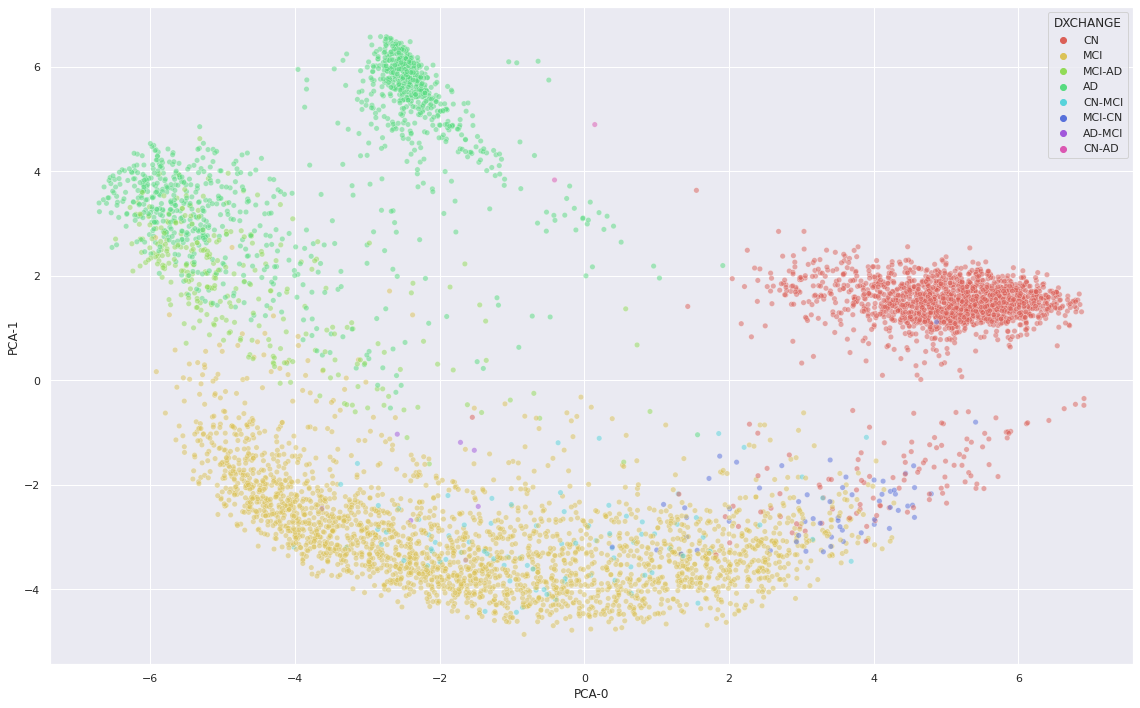

In [62]:
full_pca_result = pca_result.replace({"DXCHANGE":mapping})
plt.figure(figsize=(16,10))
color = "DXCHANGE"
ax = sns.scatterplot(
    x="PCA-0", y="PCA-1",
    hue=color,  
    #style="PTGENDER",
    s = 30,
    palette=sns.color_palette("hls", 8),
    data=full_pca_result,
    legend="full",
    alpha=0.5
)
plt.tight_layout()
plt.savefig("figures/results/{}_hidden_states_pca_color_{}_all_.png".format(folder,color))

In [64]:
ticks = ax.get_xlim()
xstart, xend = (ticks[0],ticks[-1])
ticks = ax.get_ylim()
ystart, yend = (ticks[0],ticks[-1])

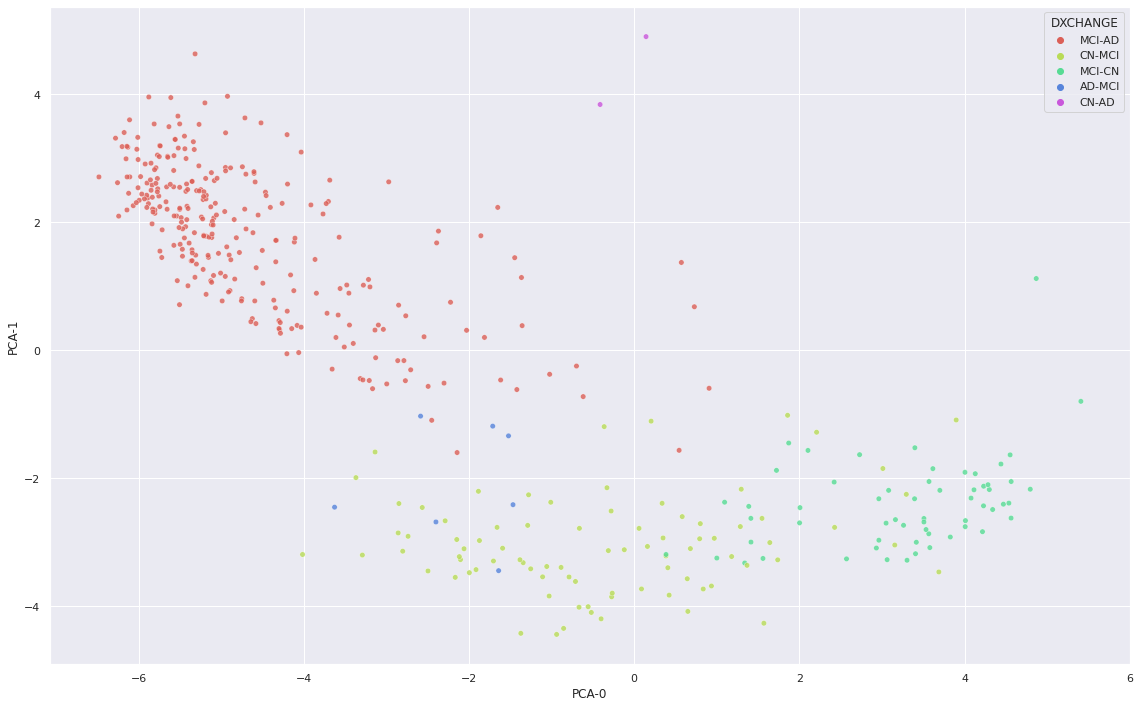

In [65]:
pca_result_ad = pca_result.copy()
#pca_result_ad.DXCHANGE = pca_result_ad.DXCHANGE.where(((pca_result_ad.DXCHANGE != 5)), 3)
pca_result_ad.DXCHANGE = pca_result_ad.DXCHANGE.where(((pca_result_ad.DXCHANGE >3)), 0)
pca_result_ad = pca_result_ad.drop(pca_result_ad[pca_result_ad.DXCHANGE == 0].index)
pca_result_ad = pca_result_ad.replace({"DXCHANGE":mapping})

plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x="PCA-0", y="PCA-1",
    hue="DXCHANGE",  
    #style="PTGENDER",
    s = 30,
    palette=sns.color_palette("hls", 5),
    data=pca_result_ad,
    legend="full",
    alpha=0.8
)
plt.xlim([xstart,xend])
plt.ylim([ystart,yend])
plt.tight_layout()

plt.savefig("figures/results/classifier_hidden_states_pca_color_{}.png".format(color))

In [113]:
pca_result_mci_ad_transitioners = pca_result.copy()
pca_result_mci_ad_transitioners.DXCHANGE = pca_result_mci_ad_transitioners.DXCHANGE.where(pca_result_mci_ad_transitioners.DXCHANGE == 5, 0)
pca_result_mci_ad_transitioners = pca_result_mci_ad_transitioners.drop(pca_result_mci_ad_transitioners[pca_result_mci_ad_transitioners.DXCHANGE == 0].index)


pca_result_mci_ad_transitioners.DXCHANGE = pca_result_mci_ad_transitioners.DXCHANGE.map(mapping)
pca_result_mci_ad_transitioners

,RID,TP,DX,DX_mask,hidden_0,hidden_1,hidden_2,hidden_3,hidden_4,hidden_5,...,hidden_123,hidden_124,hidden_125,hidden_126,hidden_127,cluster,DXCHANGE,PCA-0,PCA-1,PCA-2
56,30.0,6.0,2.0,1.0,0.509573,0.003358,-0.206600,-0.227967,0.373774,-0.015723,...,0.257633,-0.073832,0.161207,0.143899,0.795335,3,MCI-AD,0.909911,-0.941816,-2.063610
68,42.0,12.0,2.0,1.0,0.736114,0.008294,-0.408027,-0.485327,0.076179,0.020427,...,-0.139805,-0.039580,0.094994,0.449341,0.256196,0,MCI-AD,1.067145,-2.773516,0.681130
85,45.0,12.0,2.0,1.0,0.751413,0.145757,-0.153273,-0.495200,0.125678,-0.549045,...,0.234207,0.018846,0.265597,-0.066915,0.673511,4,MCI-AD,2.791647,-1.267466,-0.568580
95,50.0,6.0,2.0,1.0,0.511012,0.070068,0.154817,-0.235739,0.070040,-0.429950,...,-0.008186,-0.013018,0.176227,0.180326,0.635159,4,MCI-AD,2.164712,-0.385931,-0.365913
111,54.0,12.0,2.0,1.0,0.568860,0.256198,0.537810,-0.415220,0.143738,-0.782953,...,0.127968,0.002904,0.498272,0.098997,0.739834,4,MCI-AD,4.075981,0.500849,-0.034115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5374,4947.0,24.0,2.0,1.0,0.815448,0.132079,-0.141792,-0.376233,-0.098562,-0.194142,...,-0.184079,-0.105488,0.049084,0.381050,0.671749,4,MCI-AD,2.212728,-2.086818,-0.415933
5385,4958.0,6.0,2.0,1.0,0.442142,0.015768,-0.312100,-0.230964,-0.251859,-0.117083,...,0.301548,0.045779,0.058230,-0.061901,0.637345,5,MCI-AD,0.662127,-1.223161,-0.873722
5454,5026.0,12.0,2.0,1.0,0.732187,0.054492,-0.253715,-0.246801,-0.268925,-0.080633,...,0.080867,-0.071988,-0.085019,0.471340,-0.296633,0,MCI-AD,0.360207,-1.856238,1.987150
5463,5031.0,24.0,2.0,1.0,0.786354,0.045003,-0.408316,-0.414799,-0.011256,-0.539360,...,-0.005543,0.059849,0.186380,0.046284,0.610984,4,MCI-AD,2.703713,-1.952164,0.141045


In [114]:
pca.explained_variance_ratio_

array([0.49355483, 0.28787894, 0.04983424, 0.03021677])

In [138]:
n_clusters = 4
model = KMeans(n_clusters=n_clusters, init="k-means++", random_state=12)
x = pca_result_mci_ad_transitioners.iloc[:,4:4+128]
model.fit(x)
pca_result_mci_ad_transitioners["cluster"] = model.labels_
pca_result_mci_ad_transitioners.DXCHANGE = 5
prototypes = get_prototypes(model, n_clusters, pca_result_mci_ad_transitioners)
prototypes
for i, p in enumerate(prototypes):    
    mask = pca_result_mci_ad_transitioners.cluster == i
    c = pca_result_mci_ad_transitioners[mask]
    c.to_csv("results/mci_ad_transitioners_{}_cluster_all_{}_{}_{}.csv".format(n_clusters, i, prototypes[i][0], prototypes[i][1]))
prototype_ids = [[rid, tp] for (rid, tp, feat) in prototypes]
prototype_ids

/home/moyde/Documents/Studies/Chalmers/Thesis/LIPTraAD/venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


[[195, 12], [4502, 12], [344, 12], [179, 18]]

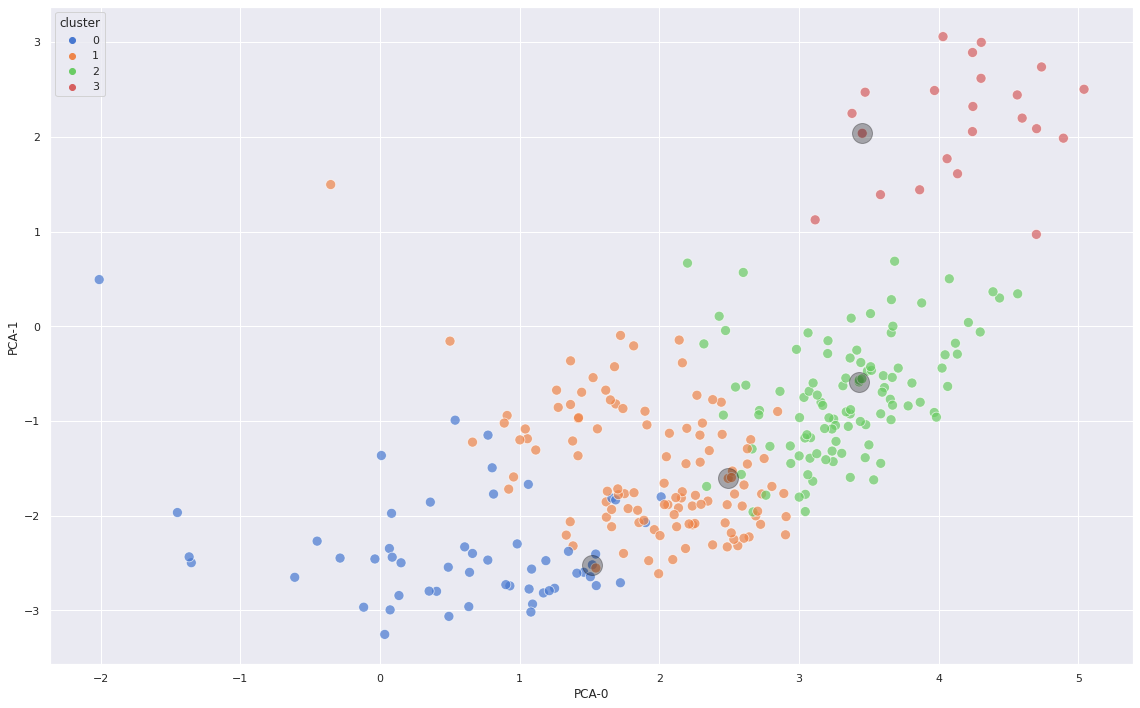

In [142]:
mapping = {
    0:0,
    1:3,
    2:1,
    3:2
}
pca_result_mci_ad_transitioners = pca_result_mci_ad_transitioners.replace({"cluster":mapping})
plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x="PCA-0", y="PCA-1",
    hue="cluster",  
    s = 100,
    palette="muted",
    data=pca_result_mci_ad_transitioners,
    legend="full",
    alpha=0.7
)
for i in range(n_clusters):    
    ax.plot([prototypes[i][2][-3]], [prototypes[i][2][-2]], color="black",marker="o", markersize=20, alpha=0.3)
#ax.get_legend().remove()
plt.tight_layout()
plt.savefig("figures/results/classifier_pca_color_cluster_mci_ad_clustering_{}_all.png".format(n_clusters))


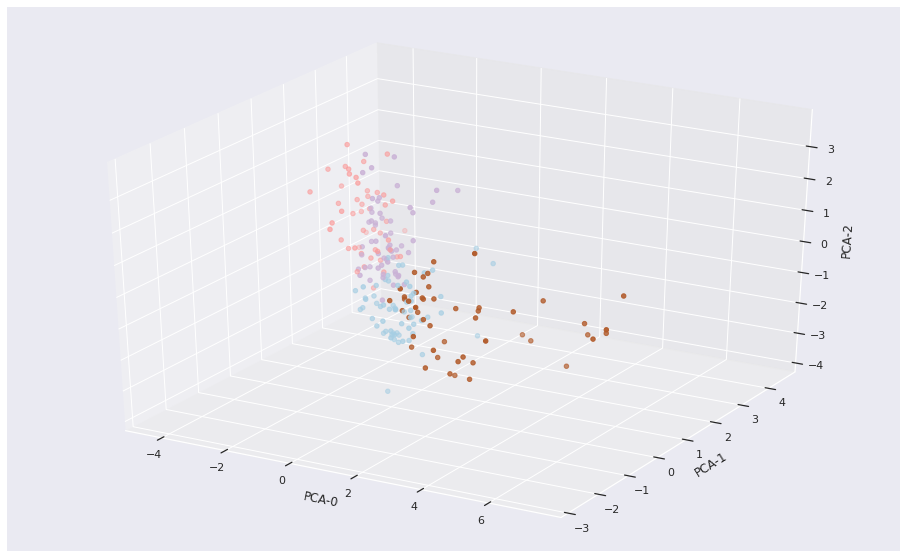

In [161]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_result_mci_ad_transitioners["PCA-0"],
    ys=pca_result_mci_ad_transitioners["PCA-1"],
    zs=pca_result_mci_ad_transitioners["PCA-2"],
    c=pca_result_mci_ad_transitioners["cluster"], 
    cmap='Paired'
)
ax.set_xlabel('PCA-0')
ax.set_ylabel('PCA-1')
ax.set_zlabel('PCA-2')
plt.savefig("figures/{}/hidden_states_pca_color_cluster_mci_ad_transitioners_4_3d.png".format(folder))